In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [3]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 2,  1,  3,  4,  7,  5, 10,  8,  0]), tensor([9, 6]))

In [4]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [5]:
import torch.nn as nn

linear_model = nn.Linear(1, 1) # <1>
linear_model(t_un_val)

tensor([[-3.7476],
        [-2.2072]], grad_fn=<AddmmBackward>)

In [6]:
linear_model.weight

Parameter containing:
tensor([[-0.5813]], requires_grad=True)

In [7]:
linear_model.bias

Parameter containing:
tensor([-0.2367], requires_grad=True)

In [8]:
x = torch.ones(1)
linear_model(x)

tensor([-0.8180], grad_fn=<AddBackward0>)

In [9]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[-0.8180],
        [-0.8180],
        [-0.8180],
        [-0.8180],
        [-0.8180],
        [-0.8180],
        [-0.8180],
        [-0.8180],
        [-0.8180],
        [-0.8180]], grad_fn=<AddmmBackward>)

In [10]:
linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(
    linear_model.parameters(), # <2>
    lr=1e-2)

In [11]:
linear_model.parameters()

<generator object Module.parameters at 0x7fa2f4898c10>

In [12]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.8817]], requires_grad=True),
 Parameter containing:
 tensor([0.2865], requires_grad=True)]

In [13]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")


In [14]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 163.5690, Validation loss 62.3141
Epoch 1000, Training loss 3.4540, Validation loss 2.9399
Epoch 2000, Training loss 2.4765, Validation loss 5.1868
Epoch 3000, Training loss 2.4448, Validation loss 5.7333

Parameter containing:
tensor([[5.5790]], requires_grad=True)
Parameter containing:
tensor([-18.4106], requires_grad=True)


In [15]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # <1>
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 266.4147, Validation loss 125.4413
Epoch 1000, Training loss 3.4371, Validation loss 2.9562
Epoch 2000, Training loss 2.4760, Validation loss 5.1922
Epoch 3000, Training loss 2.4448, Validation loss 5.7343

Parameter containing:
tensor([[5.5791]], requires_grad=True)
Parameter containing:
tensor([-18.4115], requires_grad=True)


In [16]:
seq_model = nn.Sequential(
            nn.Linear(1, 13), # <1>
            nn.Tanh(),
            nn.Linear(13, 1)) # <2>
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [17]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [18]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [19]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [20]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [21]:
seq_model.output_linear.bias

Parameter containing:
tensor([-0.0404], requires_grad=True)

In [22]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
    
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 209.9240, Validation loss 89.0376
Epoch 1000, Training loss 9.5120, Validation loss 17.9686
Epoch 2000, Training loss 2.9428, Validation loss 15.4265
Epoch 3000, Training loss 1.3867, Validation loss 12.5770
Epoch 4000, Training loss 1.0653, Validation loss 11.3041
Epoch 5000, Training loss 1.0112, Validation loss 11.0319
output tensor([[15.4145],
        [-0.6009]], grad_fn=<AddmmBackward>)
answer tensor([[13.],
        [ 3.]])
hidden tensor([[-3.0274e-02],
        [-9.3745e-03],
        [ 8.5162e+00],
        [-1.0518e+01],
        [-9.7526e+00],
        [-9.3988e+00],
        [ 7.7348e+00],
        [ 2.0265e-03]])


In [42]:
x = torch.ones(2).unsqueeze(1)
# 如何设置变量使其不需要计算梯度：
# method 1：Tensor.detach()
y = seq_model(x)
print(y)
print(y.detach())
# method 2：torch.no_grad()
with torch.no_grad():
    y = seq_model(x)
    print(y)
# method 3: change the requires_grad flags, but only work for the leaf variables
y = seq_model(x)
# you can only change requires_grad flags of leaf variables. If you want to use a computed variable in a subgraph that doesn't require differentiation use var_no_grad = var.detach().
# y.requires_grad_(False)
print(y)


tensor([[-7.0767],
        [-7.0767]], grad_fn=<AddmmBackward>)
tensor([[-7.0767],
        [-7.0767]])
tensor([[-7.0767],
        [-7.0767]])
tensor([[-7.0767],
        [-7.0767]], grad_fn=<AddmmBackward>)


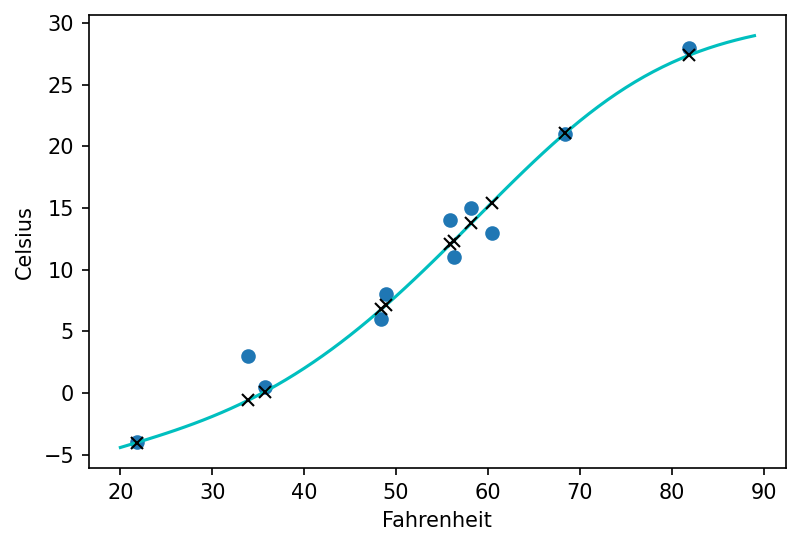

In [46]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=150)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
# real data: (x, y)
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
# generate data: t_range, model's output: seq_model(0.1 * t_range)
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')


Epoch 1, Training loss 181.9280, Validation loss 70.6710
Epoch 1000, Training loss 2.5247, Validation loss 9.0987
Epoch 2000, Training loss 4.7463, Validation loss 7.7218
Epoch 3000, Training loss 1.3597, Validation loss 7.6640
Epoch 4000, Training loss 1.0985, Validation loss 7.9820
Epoch 5000, Training loss 0.9831, Validation loss 8.3671


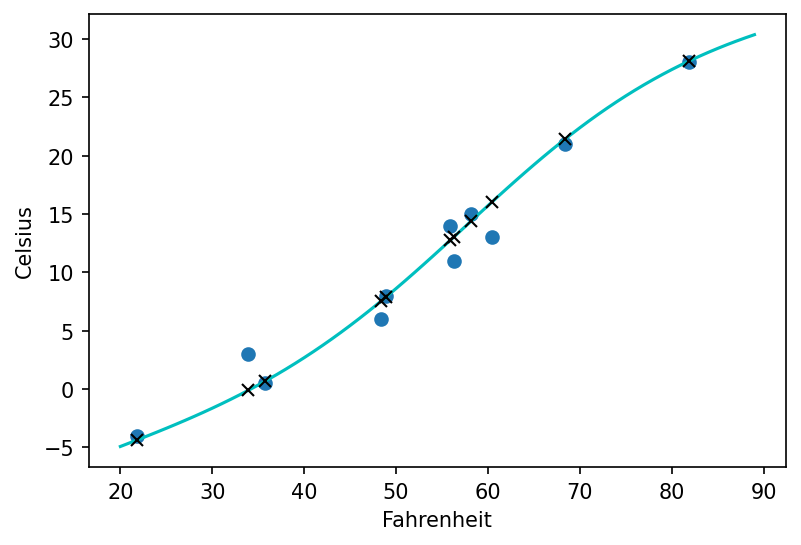

In [49]:
# Exercises here!

neuron_count = 20

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, neuron_count)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(neuron_count, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=150)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')
